<a href="https://colab.research.google.com/github/vardhanreddy-t/mini_project/blob/main/Sentiment_Analysis_for_Financial_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf

# Download dataset 'ankurzing/sentiment-analysis-for-financial-news' using Kaggle API
ankurzing_sentiment_analysis_for_financial_news_path = kagglehub.dataset_download('ankurzing/sentiment-analysis-for-financial-news')
print('Data source import complete.')


Data source import complete.


In [ ]:
# List all files in Kaggle's input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
# Install Kaggle API and download the dataset directly from Kaggle
!pip install kaggle
!kaggle datasets download -d ankurzing/sentiment-analysis-for-financial-news -p . --unzip


Dataset URL: https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news
License(s): CC-BY-NC-SA-4.0
100% 903k/903k [00:00<00:00, 998kB/s]
100% 903k/903k [00:00<00:00, 998kB/s]


In [ ]:
# Define path to CSV file and load it into a pandas DataFrame
file_path = 'all-data.csv'
df = pd.read_csv(file_path, encoding='latin-1')
print(df.head())  # Print first few rows to verify data loading


    neutral  \
0   neutral   
1  negative   
2  positive   
3  positive   
4  positive   

  According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .  
0  Technopolis plans to develop in stages an area...                                                                               
1  The international electronic industry company ...                                                                               
2  With the new production plant the company woul...                                                                               
3  According to the company 's updated strategy f...                                                                               
4  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...                                                                               


In [ ]:
# Rename columns for better readability
df = df.rename(columns={'neutral': 'Sentiment',
                        'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .' : 'Text' })
df.head()


,Sentiment,Text
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


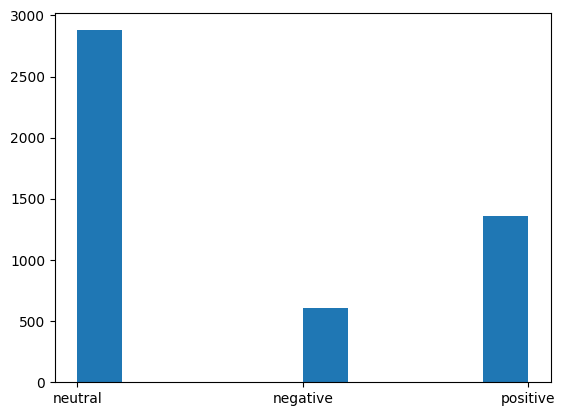

In [ ]:
# Plot distribution of sentiment classes
plt.hist(df.Sentiment)
plt.show()

# Note that data is imbalanced


In [ ]:
from sklearn.model_selection import train_test_split
# Assuming data is in a DataFrame `df` with columns `text` and `label`

train_data, temp_data = train_test_split(df, test_size=0.4, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))


Training set size: 2907
Validation set size: 969
Test set size: 969


In [ ]:
import spacy
from spacy.lang.en import English

# Load English vocabulary
nlp = English()
nlp_ = spacy.load('en_core_web_sm')
en_vocab = list(nlp_.vocab.strings)

# Identify words not in the English vocabulary
not_in_vocab = []
for i, row in df.iterrows():
    sentence = set(nlp(row.Text))
    vocab = set(en_vocab)
    not_in_vocabs = sentence.difference(vocab)
    for j in list(not_in_vocabs):
        not_in_vocab.append(j)

# Check for specific words like 'percentage'
df[df.Text.str.contains('percentage') == True]['Text']


,Text
361,Return on capital employed rose by 4.8 percent...
3884,The percentages of shares and voting rights ha...
4389,"As capacity was cut with 1.4 % , the passenger..."
4396,"Finnair 's passenger load factor , which measu..."
4689,Market share decreased on the route between He...


In [ ]:
# Define text-cleaning function
import re

def clean_text(sentence):
    sentence = re.sub('[^a-zA-Z%\s]', '', sentence)  # Remove non-alphabet characters
    sentence = re.sub('(\s*mn\s*)', 'market neutral', sentence)
    sentence = re.sub('(\s*bln\s*)', 'billion', sentence)
    sentence = re.sub('(\s*mln\s*)', 'million', sentence)
    sentence = re.sub('(pct)|%', 'percentage', sentence)
    return sentence

# Apply cleaning function to the text column
sentences = [clean_text(sent) for sent in df.Text]
df['Cleaned_text'] = sentences


In [ ]:
# Verify text cleaning
df[df.Cleaned_text.str.contains('%') == True]['Cleaned_text']


,Cleaned_text


In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Initialize stemmer and apply it to each sentence
ps = PorterStemmer()
for i, sent in enumerate(sentences):
    sentences[i] = word_tokenize(sent)
    for j, word in enumerate(sentences[i]):
        sentences[i][j] = ps.stem(word)
        if i == 1000:
            print(word, ':', ps.stem(word))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Amer : amer
Sports : sport
divests : divest
an : an
industrial : industri
site : site
in : in
Rumilly : rumilli
France : franc
This : thi
announcement : announc
is : is
distributed : distribut
by : by
Thomson : thomson
Reuters : reuter
on : on
behalf : behalf
of : of
Thomson : thomson
Reuters : reuter
clients : client


In [ ]:
# Label encoding and tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(sentences, df.Sentiment.tolist(), test_size=0.25, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle=True)

# Tokenize and pad the sequences
sent_tokenizer = Tokenizer()
sent_tokenizer.fit_on_texts(X_train)
train_sequences = sent_tokenizer.texts_to_sequences(X_train)
test_sequences  = sent_tokenizer.texts_to_sequences(X_test)
val_sequences   = sent_tokenizer.texts_to_sequences(X_val)
max_len = max(list(map(len, train_sequences)))

padded_train = pad_sequences(train_sequences, maxlen=max_len, padding='post')
padded_test  = pad_sequences(test_sequences, maxlen=max_len, padding='post')
padded_val   = pad_sequences(val_sequences, maxlen=max_len, padding='post')


In [ ]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(df.Sentiment.tolist())
y_train = np.array(label_tokenizer.texts_to_sequences(y_train)) - 1
y_test = np.array(label_tokenizer.texts_to_sequences(y_test)) - 1
y_val = np.array(label_tokenizer.texts_to_sequences(y_val)) - 1


In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Flatten
from tensorflow.keras.models import Model

# Define LSTM model
class LSTM_(Model):
    def __init__(self, vocab_size=6233, embedding_dim=32, input_length=50, n_classes=3, inp_shape=50):
        super().__init__()
        self.input_ = Input(shape=(inp_shape,))
        self.embedding = Embedding(vocab_size, embedding_dim, input_length=input_length)
        self.lstm = LSTM(16, return_sequences=True)
        self.dense = Dense(16, activation='relu')
        self.last_dense = Dense(n_classes, activation='softmax')
    def call(self):
        x = self.embedding(self.input_)
        x = self.lstm(x)
        x = Flatten()(x)
        x = self.dense(x)
        x = self.last_dense(x)
        return Model(inputs=self.input_, outputs=x)

# Instantiate, compile, and train the LSTM model
model = LSTM_(6232+1, 16, padded_train.shape[1], 3, padded_train.shape[1])
lstm_model = model.call()
lstm_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
lstm_history = lstm_model.fit(padded_train, y_train, validation_data=(padded_val, y_val), epochs=20, batch_size=8)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5634 - loss: 0.9485 - val_accuracy: 0.7030 - val_loss: 0.7231
Epoch 2/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7040 - loss: 0.6786 - val_accuracy: 0.7096 - val_loss: 0.7250
Epoch 3/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7819 - loss: 0.4945 - val_accuracy: 0.6887 - val_loss: 0.8467
Epoch 4/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8240 - loss: 0.3795 - val_accuracy: 0.7019 - val_loss: 1.1019
Epoch 5/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8458 - loss: 0.3266 - val_accuracy: 0.6898 - val_loss: 1.2168
Epoch 6/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9127 - loss: 0.2249 - val_accuracy: 0.7041 - val_loss: 1.1109
Epoch 7/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9621 - loss: 0.1173 - val_accuracy: 0.7228 - val_loss: 1.5236
Epoch 8/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9785 - loss: 0.0767 - val_accuracy:

In [ ]:
# Evaluate LSTM model
y_pred = np.argmax(lstm_model.predict(padded_test), axis=1)
print('LSTM Model Accuracy = ', np.sum(y_pred == y_test.reshape(y_test.shape[0])) / y_test.shape[0] * 100)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
LSTM Model Accuracy =  72.27722772277228


In [ ]:
from tensorflow.keras.layers import Bidirectional, Dropout

# Define BiLSTM model
class BiLSTM_(Model):
    def __init__(self, vocab_size=6233, embedding_dim=8, input_length=50, n_classes=3, inp_shape=50):
        super().__init__()
        self.input_ = Input(shape=(inp_shape,))
        self.embedding = Embedding(vocab_size, embedding_dim, input_length=input_length)
        self.bilstm = Bidirectional(LSTM(4))
        self.dense = Dense(4, activation='relu')
        self.last_dense = Dense(n_classes, activation='softmax', kernel_regularizer='l2')
        self.dropout = Dropout(0.2)
    def call(self):
        x = self.embedding(self.input_)
        x = self.bilstm(x)
        x = self.dropout(x)
        x = self.last_dense(x)
        return Model(inputs=self.input_, outputs=x)

# Instantiate, compile, and train the BiLSTM model
model = BiLSTM_(6232+1, 10, max_len, 3, padded_train.shape[1])
bilstm_model = model.call()
bilstm_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
bilstm_history = bilstm_model.fit(padded_train, y_train, validation_data=(padded_val, y_val), epochs=20, batch_size=8)


Epoch 1/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5424 - loss: 1.0334 - val_accuracy: 0.6436 - val_loss: 0.8261
Epoch 2/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6304 - loss: 0.8436 - val_accuracy: 0.7074 - val_loss: 0.7560
Epoch 3/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7370 - loss: 0.7015 - val_accuracy: 0.7107 - val_loss: 0.7556
Epoch 4/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7973 - loss: 0.5824 - val_accuracy: 0.7063 - val_loss: 0.7922
Epoch 5/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8090 - loss: 0.5222 - val_accuracy: 0.7217 - val_loss: 0.7977
Epoch 6/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8290 - loss: 0.4800 - val_accuracy: 0.7184 - val_loss: 0.8290
Epoch 7/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8395 - loss: 0.4578 - val_accuracy: 0.7151 - val_loss: 0.8641
Epoch 8/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8459 - loss: 0.4302 - val_accuracy

In [ ]:
# Cell 18: Compile and train the Bidirectional LSTM model
model = BiLSTM_(6232 + 1, 10, max_len, 3, padded_train.shape[1])
bilstm_model = model.call()
bilstm_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
bilstm_history = bilstm_model.fit(padded_train, y_train, validation_data=(padded_val, y_val), epochs=20, batch_size=8)


Epoch 1/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5645 - loss: 1.0302 - val_accuracy: 0.6315 - val_loss: 0.8422
Epoch 2/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6306 - loss: 0.8609 - val_accuracy: 0.7118 - val_loss: 0.7595
Epoch 3/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7344 - loss: 0.7173 - val_accuracy: 0.7250 - val_loss: 0.7389
Epoch 4/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7963 - loss: 0.6002 - val_accuracy: 0.7206 - val_loss: 0.7700
Epoch 5/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8207 - loss: 0.5098 - val_accuracy: 0.7074 - val_loss: 0.7975
Epoch 6/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8351 - loss: 0.4645 - val_accuracy: 0.7096 - val_loss: 0.8288
Epoch 7/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8432 - loss: 0.4290 - val_accuracy: 0.7173 - val_loss: 0.8731
Epoch 8/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8480 - loss: 0.4206 - val_accuracy: 0

In [ ]:
# Cell 19: Evaluate Bidirectional LSTM model on test data
y_pred_bilstm = np.argmax(bilstm_model.predict(padded_test), axis=1)
print('Accuracy = ', np.sum(y_pred_bilstm == y_test.reshape(y_test.shape[0])) / y_test.shape[0] * 100)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy =  66.006600660066
